In [1]:
import sys
sys.path.insert(1, '../')
import nirfasteruff as uff
import visualize
import scipy.io as sio
import numpy as np

In [2]:
# Let's load 3D volume. This particular one is a segmented ICBM152 head from NeuroDOT
# Note that the data type must be uint8
vol = sio.loadmat('headvol.mat')['mask']

In [3]:
# Now we can do two things: 1) call the CGAL mesher and use the result to generate the mesh,
# Or 2) directly call the mesh from volume function, which internally calls the mesher
# These are exactly equivalent, but the first routine is made available in case you wish to manually ajust the result
# or if you wish you use a different meshing algorithm
ele, nodes = uff.meshing.RunCGALMeshGenerator(vol)

# This simple call uses the default meshing parameters, which are
params = uff.utils.MeshingParams()
print(params.__dict__)

Meshing...
Running Lloyd smoothing... (up to 120s)
Running local optimization...
{'xPixelSpacing': 1.0, 'yPixelSpacing': 1.0, 'SliceThickness': 1.0, 'facet_angle': 25.0, 'facet_size': 3.0, 'facet_distance': 2.0, 'cell_radius_edge': 3.0, 'general_cell_size': 3.0, 'subdomain': array([0., 0.]), 'smooth': True, 'offset': None}


In [4]:
# The meanings of the parameters can be found in CGAL manual, and are the same as the original NIRFASTer
# Except: subdomain is a matrix specifying 'cell_size' for different labels, and 'smooth'
# enables Lloyd smoother before local optimization. This takes a bit longer, but generates much nicer meshes

# Let's say we want to make skin (label 5) meshed finer and white matter (2) coarser, and everthing else at default
params = uff.utils.MeshingParams(subdomain=np.array([[2., 5.],[5., 1.5]]), lloyd_smooth=0)
# We can see that the label-dependent cell size is defined as a matrix, in form of:
# [label1, cell_size1]
# [label2, cell_size2]
# [...]
# Whatever is not specified, general_cell_size is used. If label1==0, all regions use general_cell_size

In [5]:
# Let's re-run the meshing
ele, nodes = uff.meshing.RunCGALMeshGenerator(vol, params)

Meshing...
Running local optimization...


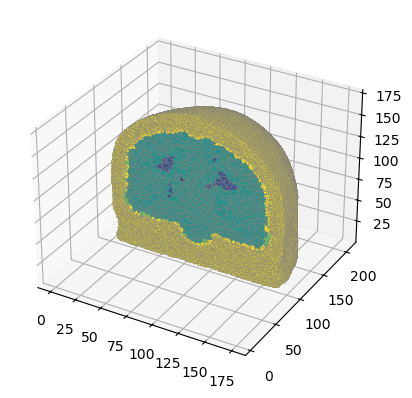

In [7]:
# Now suppose we're happy with the result, we can proceed and construct a NIRFAST mesh
mesh = uff.base.stndmesh()
mesh.from_solid(ele,nodes)
# This will generage a warning, saying that some critical information is missing. We can add them later
# Let's have a look first
# Use this hack if plt crashes
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
visualize.plot3dmesh(mesh, mesh.region, 'y>100')

In [8]:
# The optical property fields are all empty
print(mesh.mua)

[]


In [9]:
# We can then set the property using a matrix, similar to MCX format
# [region mua(mm-1) musp(mm-1) ri]
# [region mua(mm-1) musp(mm-1) ri]
# [...]
# where 'region' is the region label, and they should match exactly with unique(mesh.region). 
# The order doesn't matter
# E.g.
prop = np.array([[1, 0.004, 0.3, 1.33],
                [2, 0.0208, 1.0107, 1.33],
                [3, 0.0192, 0.6726, 1.33],
                 [4, 0.0139, 0.84, 1.33],
                 [5, 0.0190, 0.64, 1.33]])
mesh.set_prop(prop)
# take a look again. All fields should be pupulated now
print(mesh.mua)
print(mesh.kappa)
print(mesh.ksi)

[0.0192 0.0192 0.0208 ... 0.0192 0.019  0.019 ]
[0.48183483 0.48183483 0.32315398 ... 0.48183483 0.50581689 0.50581689]
[0.21292411 0.21292411 0.21292411 ... 0.21292411 0.21292411 0.21292411]


In [10]:
# Alternatively, we can combine the two steps into one
mesh = uff.base.stndmesh()
mesh.from_solid(ele, nodes, prop=prop)
# Let's also give it name
mesh.name = 'headmesh'
# and we can save it in the stand ASCII format. This should be compatible with Matlab version
mesh.save_nirfast('headmesh')

In [11]:
# The fields are all filled now. We can also specify the source and detector information by stating
# mesh.from_solid(ele, nodes, prop=prop, src=..., det=..., link=...)
# where src and det are 'uff.base.optodes' objects and link is a [NCHANNELS, 3] matrix
# We talk about this later in 'demo_full_head_model'
# Constructing the NIRFAST mesh directly from volume will also be discussed
print(mesh.name)
print(mesh.kappa)
print(mesh.element_area)

headmesh
[0.48183483 0.48183483 0.32315398 ... 0.48183483 0.50581689 0.50581689]
[0.95194122 0.54640951 5.70442488 ... 0.84489628 0.63385614 0.71296823]
